# GAN (Generative Adversarial Network)

## Theory

A Generative Adversarial Network, or GAN, is a type of neural network architecture for generative modeling.

Generative modeling involves using a model to generate new examples that plausibly come from an existing distribution of samples, such as generating new photographs that are generally similar but specifically different from a dataset of existing photographs.

A GAN is a generative model that is trained using two neural network models. One model is called the “generator” or “generative network” model, which learns to generate new plausible samples. The other model is called the “discriminator” or “discriminative network” and learns to differentiate generated examples from real examples.

The two models are set up in a contest or a game (in a game theory sense) where the generator model seeks to fool the discriminator model, and the discriminator is provided with both examples of real and generated examples.

After training, the generative model can then be used to create new plausible samples on demand.

$$\min_G \max_D V(D, G) = \mathbb{E}_{\mathbf{x} \sim p_{data}(\mathbf{x})} [\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p_{\mathbf{z}}(\mathbf{z})} [\log (1 - D(G(\mathbf{z})))]$$

+ minimax game in **Game Theory**.

+ A special case of **Adversarial Process**.

The generator is more tricky.

The GAN algorithm defines the generator model’s loss as minimizing the log of the inverted probability of the discriminator’s prediction of fake images, averaged over a mini-batch. This is straightforward, but according to the authors, it is not effective in practice when the generator is poor and the discriminator is good at rejecting fake images with high confidence. The loss function no longer gives good gradient information that the generator can use to adjust weights and instead saturates.

Instead, the authors recommend maximizing the log of the discriminator’s predicted probability for fake images.

The change is subtle. In the first case, the generator is trained to minimize the probability of the discriminator being correct. With this change to the loss function, the generator is trained to maximize the probability of the discriminator being incorrect.

## Advantages and Limitations

+ Probability distribution of data $p_{data}$ might be a very complicated distribution and very hard and intractable to infer. So, having a generative machine that could generate samples from $p_{data}$ without having to deal with nasty probability distribution is very nice.

+ Unstable.

+ Vanishing gradients for the samples that are on the correct side of the decision boundary, but are still far from the real data.

The standard Generative Adversarial Network, or GAN for short, is an effective architecture for training an unsupervised generative model.

The architecture involves training a discriminator model to tell the difference between real (from the dataset) and fake (generated) images, and using the discriminator, in turn, to train the generator model. The generator is updated in such a way that it is encouraged to generate images that are more likely to fool the discriminator.

The discriminator is a binary classifier and is trained using binary cross-entropy loss function. A limitation of this loss function is that it is primarily concerned with whether the predictions are correct or not, and less so with how correct or incorrect they might be.

This can be conceptualized in two dimensions as a line or decision boundary separating dots that represent real and fake images. The discriminator is responsible for devising the decision boundary to best separate real and fake images and the generator is responsible for creating new points that look like real points, confusing the discriminator.

The choice of cross-entropy loss means that points generated far from the boundary are right or wrong, but provide very little gradient information to the generator on how to generate better images.

This small gradient for generated images far from the decision boundary is referred to as a vanishing gradient problem or a loss saturation. The loss function is unable to give a strong signal as to how to best update the model.

## References

Ian J. Goodfellow, et al., Generative Adversarial Nets, NIPS 2014.

Tim Salimans, Ian Goodfellow, et al., Improved Techniques for Training GANs, NIPS 2016.

Ian J. Goodfellow, Tutorial: Generative Adversarial Networks, NIPS 2016.

In [1]:
import os
import time
import numpy as np

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True, source_url= 'http://yann.lecun.com/exdb/mnist/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
mb_size = 128
X_dim = mnist.train.images.shape[1]
Z_dim = 100
h_dim = 128

+ Initialization

In [4]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [5]:
X = tf.placeholder(tf.float32, shape=[None, X_dim])

D_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

+ Latent/hidden variable $z$ can sample from any distributions, e.g., uniform distribution or normal distribution.

In [6]:
def sample_Z(m, n):
    
    return np.random.uniform(-1., 1., size=[m, n])

+ Generator $G$ and Discriminator $D$ are two networks, e.g., ConvNets or Multi-Layer Perceptrons (MLP). Here, Two-Layer Full-Connected Forward Feedback NN.

In [7]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob

def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

In [8]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [9]:
G_sample = generator(Z)

D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

+ Loss functions
+ We can use some optimization algorithms with different learning rates

In [10]:
# D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
# G_loss = -tf.reduce_mean(tf.log(D_fake))

# Alternative losses:
# -------------------
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


+ Here, $k = 1$

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('GAN-GAN/'):
    os.makedirs('GAN-GAN/')

avg_costs = {'discriminator': [], 'generator': []}    

i = 0

start = time.time()
for it in range(50000):
    X_mb, _ = mnist.train.next_batch(mb_size)
    Z_noise = sample_Z(mb_size, Z_dim)

    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: Z_noise})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: Z_noise})
    
    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D_loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print('\n')
        
        n_sample = 16
        
        samples = sess.run(G_sample, feed_dict={Z: sample_Z(n_sample, Z_dim)})

        fig = plot(samples)
        plt.savefig('GAN-GAN/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)
        
        avg_costs['discriminator'].append(D_loss_curr / n_sample)
        avg_costs['generator'].append(G_loss_curr / n_sample)
        
elapsed = time.time() - start

Iter: 0
D_loss: 1.47
G_loss: 2.066


Iter: 1000
D_loss: 0.008882
G_loss: 6.326


Iter: 2000
D_loss: 0.05739
G_loss: 4.679


Iter: 3000
D_loss: 0.1483
G_loss: 5.583


Iter: 4000
D_loss: 0.2945
G_loss: 6.199


Iter: 5000
D_loss: 0.2928
G_loss: 4.327


Iter: 6000
D_loss: 0.3699
G_loss: 6.487


Iter: 7000
D_loss: 0.3465
G_loss: 4.17


Iter: 8000
D_loss: 0.2876
G_loss: 3.738


Iter: 9000
D_loss: 0.3666
G_loss: 3.602


Iter: 10000
D_loss: 0.6689
G_loss: 2.809


Iter: 11000
D_loss: 0.7551
G_loss: 3.081


Iter: 12000
D_loss: 0.3548
G_loss: 3.523


Iter: 13000
D_loss: 0.5031
G_loss: 3.083


Iter: 14000
D_loss: 0.6855
G_loss: 2.772


Iter: 15000
D_loss: 0.5281
G_loss: 2.808


Iter: 16000
D_loss: 0.6833
G_loss: 2.323


Iter: 17000
D_loss: 0.5369
G_loss: 2.669


Iter: 18000
D_loss: 0.6479
G_loss: 2.368


Iter: 19000
D_loss: 0.6755
G_loss: 2.42


Iter: 20000
D_loss: 0.56
G_loss: 2.426


Iter: 21000
D_loss: 0.849
G_loss: 2.299


Iter: 22000
D_loss: 0.6302
G_loss: 2.46


Iter: 23000
D_loss: 0.5896
G_

In [15]:
print('The elapsed time after training the network is %.2fs'%elapsed)

The elapsed time after training the network is 430.93s


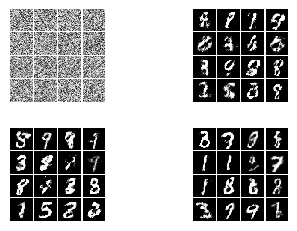

In [13]:
plt.figure()

ax = plt.subplot(221)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan1 = plt.imread('GAN-GAN/000.png')
plt.imshow(gan1, cmap='Greys_r')

ax = plt.subplot(222)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan2 = plt.imread('GAN-GAN/015.png')
plt.imshow(gan2, cmap='Greys_r')

ax = plt.subplot(223)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan3 = plt.imread('GAN-GAN/030.png')
plt.imshow(gan3, cmap='Greys_r')

ax = plt.subplot(224)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan4 = plt.imread('GAN-GAN/045.png')
plt.imshow(gan4, cmap='Greys_r')

plt.show()

+ Performance estimation

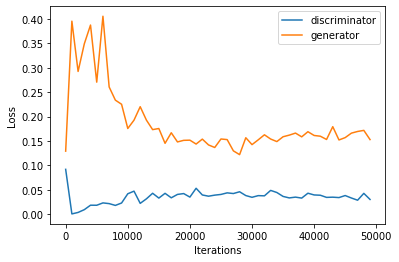

In [14]:
# plotting the learning curves
plt.figure()
plt.plot(np.arange(len(avg_costs['discriminator']))*1000, avg_costs['discriminator'], label='discriminator')
plt.plot(np.arange(len(avg_costs['generator']))*1000, avg_costs['generator'], label='generator')
plt.xlabel(r'Iterations')
plt.ylabel(r'Loss')
plt.legend()
plt.show()